# Measure the radial velocity
This notebook uses the RVFitter class to do an MCMC fit. It looks up the spectral type on Simbad to estimate the temperature, and estimates the log(g) from the spectrum (you should have a Balmer line in there somewhere).

In [4]:
# Import a bunch of stuff
import StarData
import HelperFunctions
import Fitters
import Mamajek_Table
import SpectralTypeRelations
import matplotlib.pyplot as plt
import logging
import triangle
from astropy.io import fits
import numpy as np
import sys
import os

%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Get the HDF5 filename. Might want to change this eventually.
home = os.environ['HOME']
sys.path.append('{}/School/Research/CHIRON_data/Chiron-Scripts/'.format(home))
from Search_slow import hdf5_filename
hdf5_filename = '/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid.hdf5'
reload(Fitters)

<module 'Fitters' from '/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py'>

In [2]:
# This function looks up the spectral type from simbad and uses the table from 
#  Pecaut & Mamajek to convert that into an effective temperature.

MT = Mamajek_Table.MamajekTable()
MS = SpectralTypeRelations.MainSequence()
sptnum2teff = MT.get_interpolator('SpTNum', 'Teff') 

def make_fitter(fname, Teff=None, logg=4.0, feh=0.0, first_order=3, last_order=19):
    orders = HelperFunctions.ReadExtensionFits(fname)
    
    if Teff is None:
        header = fits.getheader(fname)
        starname = header['OBJECT']
        SpT = StarData.GetData(starname).spectype
        Teff = sptnum2teff(MS.SpT_To_Number(SpT))

    # make sure Teff is in the grid
    hdf5_int = Fitters.StellarModel.HDF5Interface(hdf5_filename)
    grid_teffs = np.unique([d['temp'] for d in hdf5_int.list_grid_points])
    if Teff > max(grid_teffs):
        Teff = max(grid_teffs)
    #idx = np.argmin((grid_teffs - Teff)**2)
    #Teff = grid_teffs[idx]
    print(Teff)


    print(hdf5_filename)
    fitter = Fitters.RVFitter(orders[first_order:last_order+1], model_library=hdf5_filename, 
                              T=Teff, logg=logg, feh=feh, norm_model=False)
    return fitter

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): simbak.cfa.harvard.edu


10700.0
/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid.hdf5
Determine Chunk Log: Wl is 65536

INFO:root:Guessing initial parameters via cross-correlation...



[43.706964760864579, 133.15789473684211, 0.5, array(10700.0), array(10700.0)]

INFO:root:Estimating log(g) and Teff...
INFO:root:Best log(g) = 3.97
INFO:root:Best Teff   = 10717.24
INFO:root:RE-Guessing inital RV and Vsini for updated logg and Teff



[43.706964760864579, 153.68421052631578, 0.5, 10717.241379310344, 10717.241379310344]


<IPython.core.display.Javascript object>


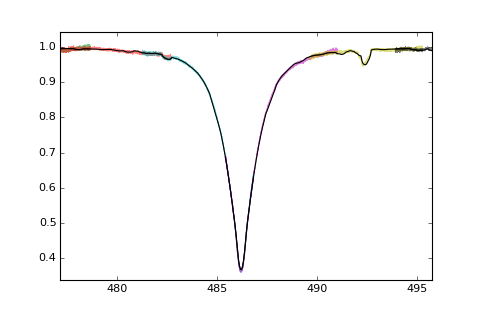

In [10]:
# Use the fitter to flatten the spectrum
#fitter = make_fitter('Adam_Data/20140210/HIP_56561.fits', logg=4.0, first_order=3, last_order=19)
fitter = make_fitter('20150113/HIP_24505.fits', logg=4.0, first_order=3, last_order=19)
%matplotlib notebook
flattened_orders = fitter.flatten_spectrum(plot=True, update_logg=False, update_teff_logg=True, 
                                           N=30, vsini_trials=20, refine=False)

10700.0
/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid.hdf5
Determine Chunk Log: Wl is 65536


<IPython.core.display.Javascript object>


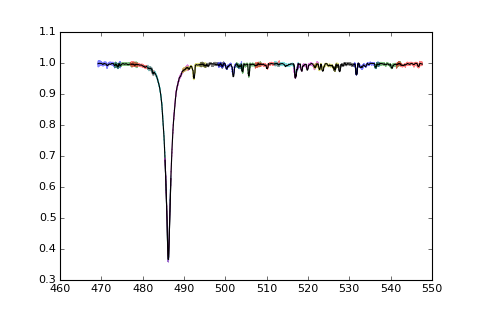

In [26]:
reload(Fitters)
fitter = make_fitter('20150113/HIP_24505.fits', logg=4.0, first_order=3, last_order=19)
fitter.update_model(Teff=10717.241379310344, logg=3.97)
%matplotlib notebook
flattened_orders2 = fitter.flatten_spectrum(plot=True, update_logg=False, update_teff_logg=False, fitorder=3,
                                           pars=[43.706964760864579, 153.68421052631578, 0.5, 3500, 10717.241379310344])

In [6]:
# Fit the RV to the flattened spectrum
flat_fitter = Fitters.RVFitter(flattened_orders, model_library=hdf5_filename, 
                               T=fitter._T, logg=fitter._logg, feh=fitter._feh)
flat_fitter.fit(backend='multinest', n_live_points=1000, basename='RVFitter/HIP56561-', overwrite=True)

Determine Chunk Log: Wl is 65536


/home/kgullikson/.PythonModules/GeneralScripts/Fitters.py:1634: UserWarning: vsini too small (64692.4972534). Not broadening!
  linear=True, findcont=False)


<IPython.core.display.Javascript object>


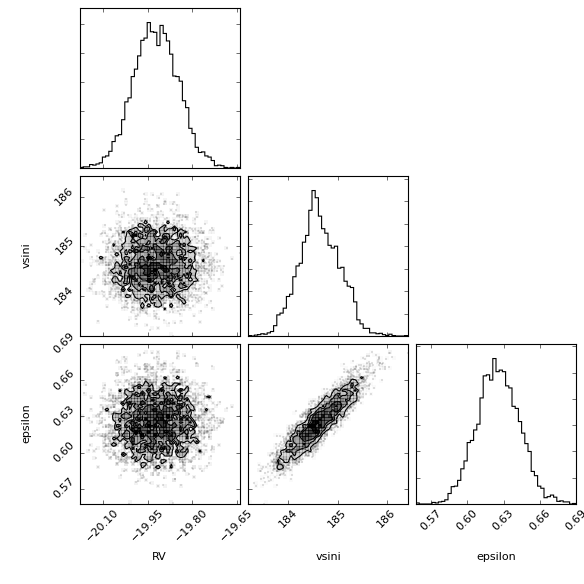

In [7]:
flat_fitter.triangle()

<IPython.core.display.Javascript object>


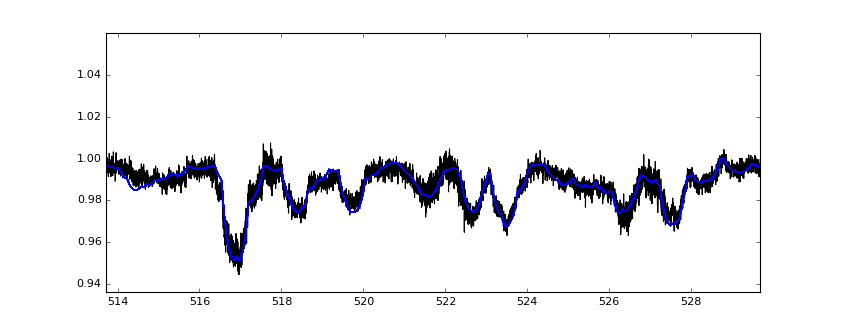

In [8]:
%matplotlib notebook
flat_fitter.plot()

In [9]:
flat_fitter.samples.describe()

,RV,epsilon,lnprob,vsini
count,4377.000000,4377.000000,4377.000000,4377.000000
mean,-19.922481,0.625690,226208.480665,184.637601
std,0.074822,0.017559,1.239798,0.414431
min,-20.177175,0.557713,226199.978082,183.181104
25%,-19.973337,0.613775,226207.934523,184.359920
50%,-19.923316,0.625233,226208.796406,184.611487
75%,-19.871694,0.637486,226209.372803,184.920385
max,-19.639667,0.689874,226210.209063,186.432555


# Does the emcee backend work?

In [17]:
emcee_fitter = Fitters.RVFitter(flattened_orders, model_library=hdf5_filename, 
                               T=fitter._T, logg=fitter._logg, feh=fitter._feh)
emcee_fitter.fit(backend='emcee', n_burn=100, n_prod=300, guess=False, initial_pars=[20.34, 160.70, 0.761])

Determine Chunk Log: Wl is 65536
Running burn-in

INFO:root:Done with burn-in iteration 1 / 100
INFO:root:Done with burn-in iteration 11 / 100
INFO:root:Done with burn-in iteration 21 / 100
INFO:root:Done with burn-in iteration 31 / 100
INFO:root:Done with burn-in iteration 41 / 100
INFO:root:Done with burn-in iteration 51 / 100
INFO:root:Done with burn-in iteration 61 / 100
INFO:root:Done with burn-in iteration 71 / 100
INFO:root:Done with burn-in iteration 81 / 100
INFO:root:Done with burn-in iteration 91 / 100



Running production

INFO:root:Done with production iteration 1 / 300
INFO:root:Done with production iteration 11 / 300
INFO:root:Done with production iteration 21 / 300
INFO:root:Done with production iteration 31 / 300
INFO:root:Done with production iteration 41 / 300
INFO:root:Done with production iteration 51 / 300
INFO:root:Done with production iteration 61 / 300
INFO:root:Done with production iteration 71 / 300
INFO:root:Done with production iteration 81 / 300
INFO:root:Done with production iteration 91 / 300
INFO:root:Done with production iteration 101 / 300
INFO:root:Done with production iteration 111 / 300
INFO:root:Done with production iteration 121 / 300
INFO:root:Done with production iteration 131 / 300
INFO:root:Done with production iteration 141 / 300
INFO:root:Done with production iteration 151 / 300
INFO:root:Done with production iteration 161 / 300
INFO:root:Done with production iteration 171 / 300
INFO:root:Done with production iteration 181 / 300
INFO:root:Done with production iteration 1

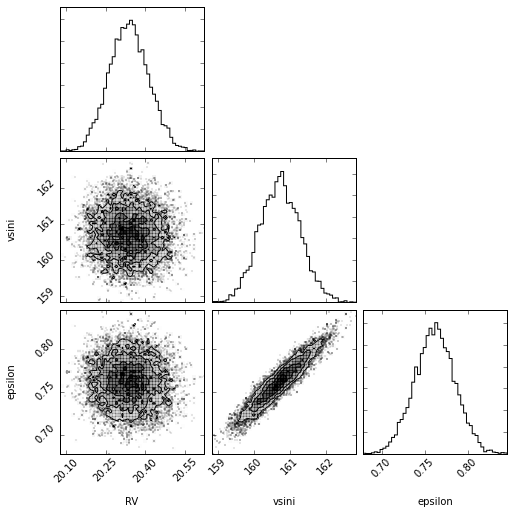

In [33]:
%matplotlib inline
emcee_fitter.triangle()

<IPython.core.display.Javascript object>


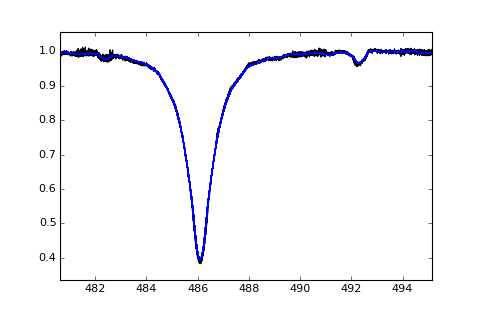

In [36]:
%matplotlib notebook
emcee_fitter.plot()

In [35]:
emcee_fitter.samples.describe()

,RV,epsilon,lnprob,vsini
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,20.337661,0.761739,210525.194550,160.727468
std,0.074593,0.023367,1.174809,0.563943
min,20.078375,0.678068,210516.721452,158.825016
25%,20.286839,0.746070,210524.625132,160.338103
50%,20.336594,0.761894,210525.482334,160.724248
75%,20.387914,0.777517,210526.070139,161.110036
max,20.622756,0.845453,210526.653922,162.826189


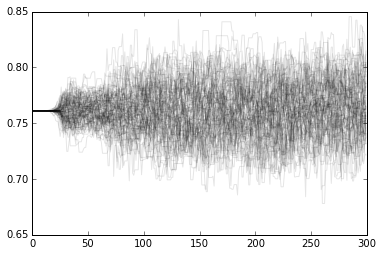

In [24]:
_ = plt.plot(emcee_fitter.sampler.chain[:, :, 2].T, 'k-', alpha=0.1)

In [32]:
ndim = 3
samples = emcee_fitter.sampler.chain[:, 100:, :].reshape((-1, ndim))
lnprob = emcee_fitter.sampler.lnprobability[:, 100:].flatten()
chain_dict = {emcee_fitter.param_names[i]: samples[:, i] for i in range(emcee_fitter.n_params)}
chain_dict['lnprob'] = lnprob

import pandas as pd
emcee_fitter.samples = pd.DataFrame(data=chain_dict)

In [30]:
emcee_fitter.sampler.lnprobability[:, 100:].flatten().shape

(20000,)